<a href="https://colab.research.google.com/gist/NanuSai/3de0b30c9e8a84aa3323a595213838be/capstone-project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (you could download the notebook with File -> Download .ipynb, open the notebook locally, and then File -> Download as -> PDF via LaTeX), and then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [29]:
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
import pandas as pd

For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images.

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

The train and test datasets required for this project can be downloaded from [here](http://ufldl.stanford.edu/housenumbers/train.tar.gz) and [here](http://ufldl.stanford.edu/housenumbers/test.tar.gz). Once unzipped, you will have two files: `train_32x32.mat` and `test_32x32.mat`. You should store these files in Drive for use in this Colab notebook.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [30]:
# Run this cell to connect to your Drive folder

# from google.colab import drive
# drive.mount('/content/gdrive')

In [31]:
!ls -lh

total 2599224
-rw-r--r--@     1 raquelredondo  staff   206K Jun 14 21:03 EuroSatNet.h5
-rw-rw-r--@     1 raquelredondo  staff   314K Jun 15 18:39 capstone-project.ipynb
-rw-rw-r--@     1 raquelredondo  staff   271K Jun 15 18:54 capstone-project_copy.ipynb
drwxr-xr-x      8 raquelredondo  staff   256B Jun 15 15:23 data_capstone
-rw-r--r--@     1 raquelredondo  staff    10K Jun 14 19:52 imagenet_categories.txt
drwxr-xr-x      9 raquelredondo  staff   288B Jun 15 18:54 model-cnn
drwxr-xr-x     35 raquelredondo  staff   1.1K Jun 15 18:48 model-mlp
drwxr-xr-x@ 13072 raquelredondo  staff   409K Dec  6  2011 test
-rw-r--r--@     1 raquelredondo  staff   264M Jun 15 09:06 test.tar.gz
-rw-r--r--@     1 raquelredondo  staff    61M Jun 15 09:08 test_32x32.mat
drwxr-xr-x@ 33406 raquelredondo  staff   1.0M Dec  6  2011 train
-rw-r--r--@     1 raquelredondo  staff   385M Jun 15 09:07 train.tar.gz
-rw-r--r--@     1 raquelredondo  staff   174M Jun 15 09:08 train_32x32.mat
-rw-r--r--@     1 raquelredon

In [32]:
# Load the dataset from your Drive folder

train = loadmat('data_capstone/train_32x32.mat')
test = loadmat('data_capstone/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [33]:
##Preprocessing

from sklearn.preprocessing import OneHotEncoder

train_x = np.transpose(train['X'], (3,0,1,2)) / 255.
test_x = np.transpose(test['X'], (3,0,1,2)) / 255.
 
encoder = OneHotEncoder(sparse=False)

train_y = encoder.fit_transform(train['y'] % 10)
test_y = encoder.fit_transform(test['y'] % 10)

In [34]:
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(73257, 32, 32, 3)
(26032, 32, 32, 3)
(73257, 10)
(26032, 10)


In [35]:
#Show random images
import random
import matplotlib.pyplot as plt

def random_imgs(x, y):
    num_samples = x.shape[0] 
    indexs = random.sample(range(0, num_samples + 1), 15)
    fig, axs = plt.subplots(nrows = 3, ncols = 5, figsize=(10,10))

    for idx, ax in zip(indexs, axs.flatten()):
        #usual case
        if(x[idx].shape == (32,32,3)):
            ax.imshow(x[idx])
        else: #graymap
            ax.imshow(x[idx,...,0],cmap='gray')
        ax.set_xlabel("label: " + str(np.argmax(y[idx])))


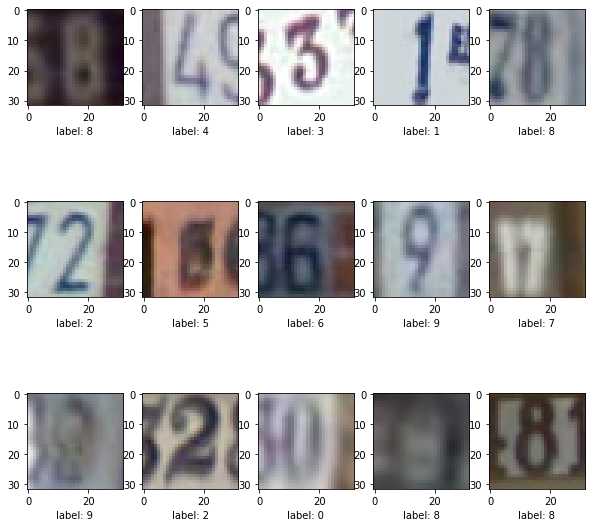

In [36]:
random_imgs(train_x, train_y)

In [37]:
#Take mean and reshape

#Weighted average
def rgb2gray(img):
        return np.dot(img, [0.2989, 0.5870, 0.1140])[...,np.newaxis]
    
train_x_gray = rgb2gray(train_x).astype(np.float32)
test_x_gray = rgb2gray(test_x).astype(np.float32)

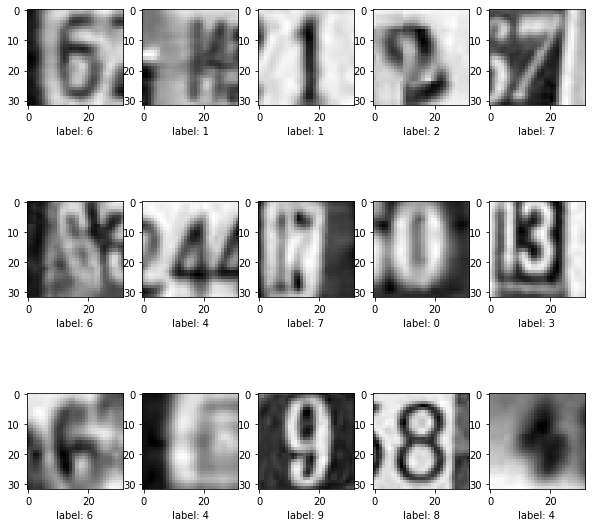

In [38]:
random_imgs(train_x_gray,  train_y)

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.regularizers import l1_l2

In [40]:
def get_test_results(model):
    test_loss, test_accuracy = model.evaluate(test_x_gray, test_y, verbose = False)
    print(f"Test accuracy is {test_accuracy}")
    print(f"Test loss is {test_loss}")

In [41]:
def plot_models(history):
    
    
    fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize=(10,10))
    axs[0].plot(history['val_loss'], label = 'validation loss', color = 'orange')
    axs[0].plot(history['loss'], label = 'training loss', color = 'blue')
    axs[0].set_ylabel('val loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend()
    axs[1].plot(history['val_accuracy'], label = 'validation accuracy',color = 'orange')
    axs[1].plot(history['accuracy'], label = 'training accuracy',color = 'blue')
    axs[1].set_ylabel('val accuracy')
    axs[1].legend()
    axs[1].set_xlabel('epoch')
    

In [68]:
def get_mlp_model(input_shape):
    
    return Sequential([
        Flatten(name='flatten_1', input_shape = input_shape),
        Dense(32, activation = 'relu'),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(32, activation='relu'),
        Dense(10, activation='softmax')
    ])

shape = train_x_gray[0].shape
model = get_mlp_model(shape)

In [69]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 1024)              0         
                                                                 
 dense_33 (Dense)            (None, 32)                32800     
                                                                 
 dense_34 (Dense)            (None, 32)                1056      
                                                                 
 dense_35 (Dense)            (None, 32)                1056      
                                                                 
 dense_36 (Dense)            (None, 32)                1056      
                                                                 
 dense_37 (Dense)            (None, 32)                1056      
                                                                 
 dense_38 (Dense)            (None, 32)               

In [70]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def get_callbacks(model_type):
    
    early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, verbose = 1)
    plateau = ReduceLROnPlateau(monitor='val_loss', patience = 10, factor = 0.2)
    
    checkp_path = 'model-' + model_type + '/checkpoint-epoch: {epoch:02d}'
    checkp = ModelCheckpoint(filepath=checkp_path, monitor='val_accuracy',save_weights_only=True,
                                save_best_only = True, verbose = 1)
    
    return early_stop, plateau, checkp

In [71]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [72]:
early_stop, plateau, checkp = get_callbacks('mlp')
history_mlp= model.fit(train_x_gray, train_y, 
                       epochs = 30, 
                       callbacks= [early_stop, plateau, checkp], 
                       validation_split=0.15)

Epoch 1/30
1943/1946 [============================>.] - ETA: 0s - loss: 2.1182 - accuracy: 0.2325
Epoch 1: val_accuracy improved from -inf to 0.25644, saving model to model-mlp/checkpoint-epoch: 01
1946/1946 [==============================] - 8s 4ms/step - loss: 2.1179 - accuracy: 0.2325 - val_loss: 2.0322 - val_accuracy: 0.2564 - lr: 0.0010
Epoch 2/30
1943/1946 [============================>.] - ETA: 0s - loss: 1.8062 - accuracy: 0.3433
Epoch 2: val_accuracy improved from 0.25644 to 0.44144, saving model to model-mlp/checkpoint-epoch: 02
1946/1946 [==============================] - 6s 3ms/step - loss: 1.8057 - accuracy: 0.3436 - val_loss: 1.5993 - val_accuracy: 0.4414 - lr: 0.0010
Epoch 3/30
1946/1946 [==============================] - ETA: 0s - loss: 1.5184 - accuracy: 0.4659
Epoch 3: val_accuracy improved from 0.44144 to 0.49431, saving model to model-mlp/checkpoint-epoch: 03
1946/1946 [==============================] - 6s 3ms/step - loss: 1.5184 - accuracy: 0.4659 - val_loss: 1.448

Epoch 26/30
1944/1946 [============================>.] - ETA: 0s - loss: 1.0765 - accuracy: 0.6583
Epoch 26: val_accuracy improved from 0.65365 to 0.66021, saving model to model-mlp/checkpoint-epoch: 26
1946/1946 [==============================] - 9s 4ms/step - loss: 1.0763 - accuracy: 0.6583 - val_loss: 1.0728 - val_accuracy: 0.6602 - lr: 0.0010
Epoch 27/30
1942/1946 [============================>.] - ETA: 0s - loss: 1.0729 - accuracy: 0.6588
Epoch 27: val_accuracy did not improve from 0.66021
1946/1946 [==============================] - 7s 3ms/step - loss: 1.0729 - accuracy: 0.6588 - val_loss: 1.0955 - val_accuracy: 0.6488 - lr: 0.0010
Epoch 28/30
1940/1946 [============================>.] - ETA: 0s - loss: 1.0683 - accuracy: 0.6601
Epoch 28: val_accuracy did not improve from 0.66021
1946/1946 [==============================] - 9s 5ms/step - loss: 1.0685 - accuracy: 0.6600 - val_loss: 1.0760 - val_accuracy: 0.6598 - lr: 0.0010
Epoch 29/30
1945/1946 [============================>.] - 

In [61]:
get_test_results(model)


Test accuracy is 0.7468884587287903
Test loss is 0.823851466178894


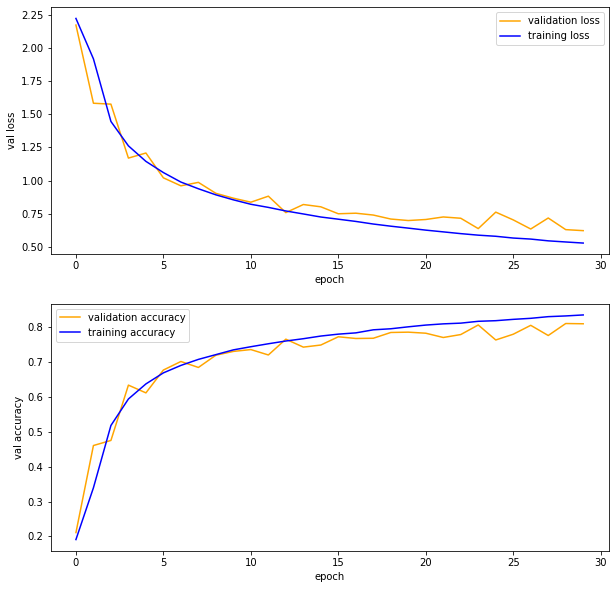

In [48]:
plot_models(history_mlp.history)

## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [0]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout

def get_cnn_model(input_shape, keep_prob):
    
    return Sequential([
        Conv2D(32, kernel_size = 3, 
               input_shape=input_shape, name='conv_1'
               ,activation='relu'),
        Conv2D(16, kernel_size = 3 , name='conv_2', activation='relu'),
        MaxPool2D(pool_size=2, name='pool_1'),
        Flatten(name='flatten_1'),
        Dense(32, activation='relu', name = 'dense_1'),
        Dropout(keep_prob),
        Dense(32, activation='relu', name = 'dense_3'),
        BatchNormalization(),
        Dense(10, activation='softmax',name='output')
    ])
    

In [0]:
shape = train_x_gray[0].shape
model = get_cnn_model(shape, 0.3)

In [79]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv_2 (Conv2D)              (None, 28, 28, 16)        4624      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 14, 14, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                100384    
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)              

In [0]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [26]:
early_stop, plateau, checkp = get_callbacks('cnn')
history_cnn = model.fit(train_x_gray, train_y, epochs = 20, callbacks= [early_stop, plateau, checkp], validation_split=0.15)

Epoch 1/20
1939/1946 [============================>.] - ETA: 0s - loss: 1.6753 - accuracy: 0.4047
Epoch 1: val_accuracy improved from -inf to 0.39922, saving model to model-cnn/checkpoint-epoch: 01
1946/1946 [==============================] - 7s 4ms/step - loss: 1.6754 - accuracy: 0.4047 - val_loss: 1.6876 - val_accuracy: 0.3992 - lr: 0.0020
Epoch 2/20
1939/1946 [============================>.] - ETA: 0s - loss: 1.6738 - accuracy: 0.4046
Epoch 2: val_accuracy improved from 0.39922 to 0.40313, saving model to model-cnn/checkpoint-epoch: 02
1946/1946 [==============================] - 7s 4ms/step - loss: 1.6735 - accuracy: 0.4049 - val_loss: 1.6838 - val_accuracy: 0.4031 - lr: 0.0020
Epoch 3/20
1937/1946 [============================>.] - ETA: 0s - loss: 1.6735 - accuracy: 0.4058
Epoch 3: val_accuracy did not improve from 0.40313
1946/1946 [==============================] - 7s 4ms/step - loss: 1.6734 - accuracy: 0.4058 - val_loss: 1.6890 - val_accuracy: 0.4003 - lr: 0.0020
Epoch 4/20
194

KeyboardInterrupt: 

In [23]:
get_test_results(model)

Test accuracy is 0.37845727801322937
Test loss is 1.7517955303192139


In [25]:
plot_models(history_cnn.history)

NameError: name 'history_cnn' is not defined

## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [0]:
def get_best_model_mlp(model):
      checkp = tf.train.latest_checkpoint('model-mlp')
      model.compile(
          optimizer = 'adam',
          loss = 'categorical_crossentropy',
          metrics = ['accuracy']
      )
      model.load_weights(checkp)

      return model

def get_best_model_cnn(model):
      checkp = tf.train.latest_checkpoint('model-cnn')
      model.compile(
          optimizer = 'adam',
          loss = 'categorical_crossentropy',
          metrics = ['accuracy']
      )
      model.load_weights(checkp)

      return model
  
def random_img_from_model(model):
        num_samples = test_x.shape[0]
        indexs = random.sample(range(0, num_samples + 1), 6)

        fig, axs = plt.subplots(1,5, figsize = (8, 8))

        for idx, ax in zip(indexs, axs.flatten()):
              ax.imshow(test_x[idx])
              prediction = model.predict(test_x_gray[idx][np.newaxis, ...])
              ax.set_xlabel("prediction:" + str(np.argmax(prediction)))


In [0]:
model_mlp = get_best_model_mlp(get_mlp_model(train_x_gray[0].shape))
model_cnn = get_best_model_cnn(get_cnn_model(train_x_gray[0].shape, 0.3))

In [118]:
print("MLP Result: ")
get_test_results(model_mlp)

print('\n')
print('CNN Result: ')
get_test_results(model_cnn)

MLP Result: 
Test accuracy is 0.7904502153396606
Test loss is 0.7076961994171143


CNN Result: 
Test accuracy is 0.8370466828346252
Test loss is 0.5398384928703308


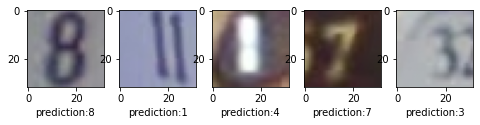

In [161]:
random_img_from_model(model_mlp)

(1, 32, 32, 1)